In [192]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [205]:
p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p) | Doc.objects.filter(technology__project=p)

trdocs = set(list(pdocs.filter(docownership__relevant=1).values_list('UT',flat=True)))

irdocs = set(list(pdocs.filter(docownership__relevant=5).values_list('UT',flat=True)))

inrateddocs = set(list(pdocs.filter(docownership__relevant__in=[5,6,7,8]).values_list('UT',flat=True)))


In [206]:
print(len(trdocs))
print(len(irdocs))
print(len(inrateddocs))

print(len(trdocs.intersection(inrateddocs)))

allreldocs = pdocs.distinct().filter(
    UT__in=trdocs.intersection(irdocs)
)

print(allreldocs.count())

1777
1792
2399
891
675


In [196]:
weird = irdocs.difference(trdocs)
weird

{'WOS:000376711000007',
 'WOS:000316606100008',
 'WOS:000258823800004',
 'WOS:000330814100055',
 'WOS:000375125200011',
 'WOS:000365070700050',
 'WOS:000279258000030',
 'WOS:000374592800007',
 'WOS:000392677200006',
 'WOS:000275841100015',
 'WOS:000244055300007',
 'WOS:000366402900019',
 'WOS:000388944200005',
 'WOS:000365026600030',
 'WOS:000286905300053',
 'WOS:000389088400005',
 'WOS:000356936200054',
 'WOS:000316002800013',
 'WOS:000337017700006',
 'WOS:000316032300046',
 'WOS:000245987300005',
 'WOS:000243803300003',
 'WOS:000379208400032',
 'WOS:000323253500039',
 'WOS:000380033400033',
 'WOS:000363531900012',
 'WOS:000273754800022',
 'WOS:000330965400010',
 'WOS:000170758900011',
 'WOS:000325665400010',
 'WOS:000339216600004',
 'WOS:000263358500008',
 'WOS:000251685100001',
 'WOS:000364247100083',
 'WOS:000227183600005',
 'WOS:000243609800002',
 'WOS:000370096200009',
 'WOS:000345075400007',
 'WOS:000376806900010',
 'WOS:000332815300064',
 'WOS:000351849700025',
 'WOS:0001799641

In [203]:
for did in list(weird)[0:5]:
    d = Doc.objects.get(pk=did)
    print('\n############')
    print(d.UT)
    print(d.title)
    for x in d.query.all():
        print("id:{} u:{} t:{} i:{}".format(
            x.pk,
            x.creator,
            x.technology,
            x.innovation
        ))


############
WOS:000376711000007
Pyrolysis of crop residues in a mobile bench-scale pyrolyser: Product characterization and environmental performance
id:36 u:galm t:None i:None
id:37 u:galm t:None i:None
id:38 u:galm t:None i:None
id:335 u:galm t:Biochar i:None
id:336 u:galm t:Biochar i:None
id:354 u:galm t:None i:None
id:365 u:galm t:None i:None
id:568 u:galm t:Biochar i:None
id:894 u:galm t:None i:None
id:1086 u:rogers t:None i:None
id:1098 u:rogers t:None i:None
id:1102 u:rogers t:None i:None
id:1106 u:rogers t:None i:None
id:1107 u:rogers t:None i:None
id:1113 u:rogers t:None i:None
id:1117 u:rogers t:None i:None
id:1174 u:rogers t:None i:None
id:1183 u:rogers t:None i:None
id:1188 u:rogers t:Soil Carbon Sequestration i:Scaleup
id:1192 u:rogers t:Soil Carbon Sequestration i:Innovationgeneral
id:1284 u:rogers t:None i:None
id:1285 u:rogers t:None i:None
id:1304 u:rogers t:None i:None
id:1497 u:lamw t:None i:None

############
WOS:000316606100008
Early Effects of Afforestation with 

In [210]:
oweird = trdocs.difference(inrateddocs)

all_inno = set(list(Doc.objects.filter(query=1106).values_list('UT',flat=True)))

len(oweird.intersection(all_inno))

uninrated = Doc.objects.filter(UT__in=list(oweird))
q = Query.objects.get(pk=1504)
for d in uninrated:
    d.query.add(q)
    d.save()

In [189]:
len(trdocs.intersection(irdocs))

675

In [211]:
allidocs = allreldocs.filter(
    docownership__relevant=5,
).values('PY','docownership__query__innovation__name').annotate(
    n = Count('pk', distinct = True)
)
df = pd.DataFrame.from_dict(list(allidocs))
df.head()

,PY,docownership__query__innovation__name,n
0,2007,RD,21
1,2012,Scaleup,20
2,2006,Scaleup,6
3,2015,RD,58
4,2004,RD,11


     PY docownership__query__innovation__name    n
0  1990                            Demandpull  0.0
1  1990                                 Demos  0.0
2  1990                          Nichemarkets  0.0
3  1990                          Publicaccept  0.0
4  1990                                    RD  0.0


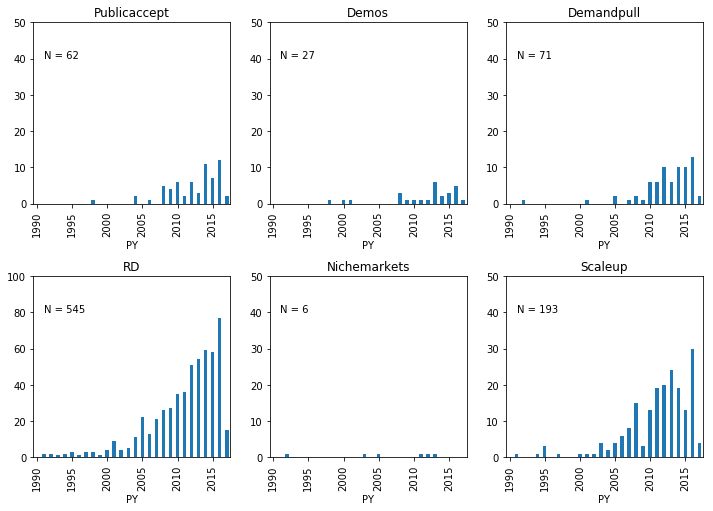

In [375]:
plt.rcParams["figure.figsize"] = [12,8]

fig, axs = plt.subplots(nrows=2,ncols=3,gridspec_kw=dict(hspace=0.4))

pt = pd.pivot_table(
    df,
    values='n',
    columns=['PY'],
    index=['docownership__query__innovation__name'],
    fill_value=0
)

fullindex = pd.DatetimeIndex(freq='1A', start='1974', end='2017')

pt = (
    df.set_index(['PY','docownership__query__innovation__name'])
        .unstack(level='docownership__query__innovation__name')
        .reindex(range(1990,2018))
        .fillna(0)
        .stack()
        .reset_index()
)

print(pt.head())


pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Scaleup",
                                                                "Demandpull",
                                                                "Publicaccept",
                                                                "Demos",
                                                                "Nichemarkets"
                                                            ])


grouped =  pt.groupby('docownership__query__innovation__name')

targets = zip(grouped.groups.keys(), axs.flatten())

n = 5

for i, (key, ax) in enumerate(targets):
    
    group = grouped.get_group(key)
    
    group = group.sort_values('PY')
    group = group.set_index('PY')
    group.plot.bar(ax=ax, legend=False)
    #ax.bar(group.index,group['n'])
    #ax.bar(group,group[['n']])
    
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n])
    
    if key=="RD":   
        m = 100
    else:   
        m = 50
        
    ax.set_ylim(0,m)
    
    
    ax.set_title(key)
    
    s = "N = {:d}".format(int(group.sum()['n']))
    
    ax.text(1,m*0.8, s)
    

plt.savefig('plots/1_1_1.png',bbox_inches='tight') 
plt.show()

339.0

In [305]:
allds = allreldocs.filter(
    docownership__relevant__in=[5,1],
).values(
    'docownership__query__innovation__name',
    'docownership__query__technology__name',
    'PY'
).annotate(
    n = Count('pk', distinct = True)
)
lallds = list(allds)
lallds.append({
    "PY":1990,
    "docownership__query__innovation__name": "Scaleup",
    "docownership__query__technology__name": "Afforestation/reforestation",
    "n": 0
})
adf = pd.DataFrame.from_dict(lallds)
adf = adf[adf['docownership__query__innovation__name'] != "None"]
adf.sort_values('PY').head()

,PY,docownership__query__innovation__name,docownership__query__technology__name,n
397,1990,Scaleup,Afforestation/reforestation,0
231,1991,Scaleup,Afforestation/reforestation,1
295,1991,None,Afforestation/reforestation,2
329,1991,RD,Afforestation/reforestation,2
96,1992,None,Afforestation/reforestation,2


In [324]:
reindexes = [
    ('PY','docownership__query__technology__name','docownership__query__innovation__name'),
    ('PY','docownership__query__innovation__name','docownership__query__technology__name'),
    ('docownership__query__innovation__name','docownership__query__technology__name','PY')
]

pt = adf

for x in reindexes:

    pt = pd.pivot_table(
        pt,
        values='n',
        columns=[x[2]],
        index=[x[0],x[1]],
        fill_value=0
    ).reset_index()


    pt = pd.melt(
        pt,
        id_vars=[x[0],x[1]],
        value_name='n'
    ).reset_index()

pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Scaleup",
                                                                "Demandpull",
                                                                "Publicaccept",
                                                                "Demos",
                                                                "Nichemarkets"
                                                            ])

pt = pt.sort_values(['PY','docownership__query__innovation__name'])


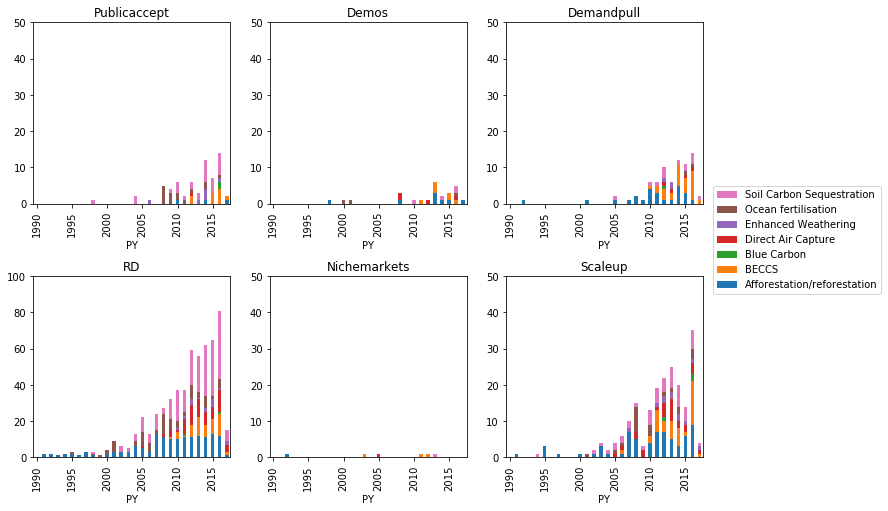

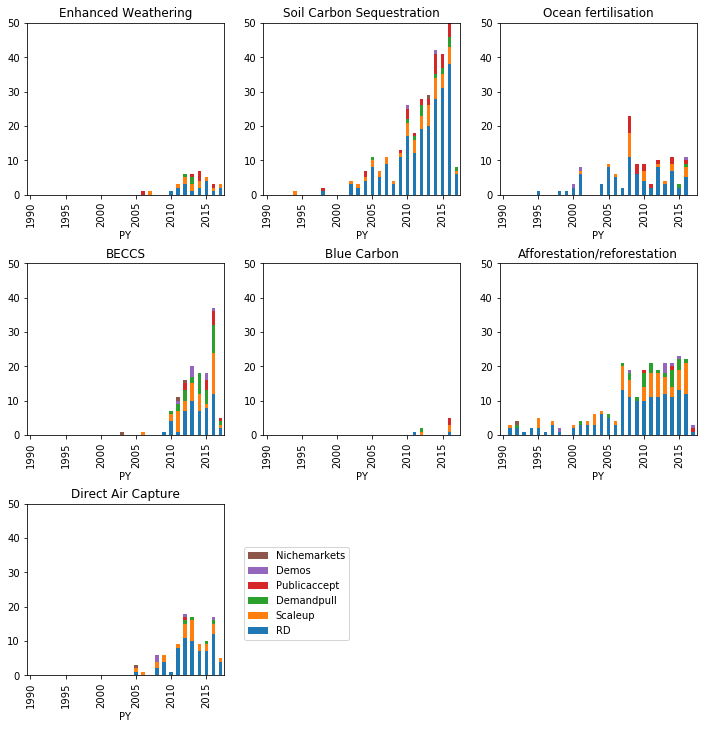

In [374]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    ('docownership__query__technology__name','docownership__query__innovation__name',3),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    grouped = pt.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())

    for i, (key, ax) in enumerate(targets):
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key)
            
            #l = ax.legend()

            if i == 0:
                #ax.legend()
                handles, labels = ax.get_legend_handles_labels()
            
            ticks = ax.xaxis.get_ticklocs()
            ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::n])
            ax.xaxis.set_ticklabels(ticklabels[::n])
            
            if key=="RD":   
                m = 100
            else:   
                m = 50
        
            ax.set_ylim(0,m)
            
            
        except:
            print(key)
            print(group)
            pass

    #plt.legend()
    #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    #fig.subplots_adjust(right=0.65)
    if x[2]==3:
        lpos = (1.1,0.75)
        axs[-1,-1].axis('off')
        axs[-1,-2].axis('off')
    else:
        lpos = (1.05,1.5)
    ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)
    plt.savefig('plots/1_1_{}.png'.format(x[2]),bbox_inches='tight') 
    plt.show()